In [93]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import cm
import os
import stumpy
from scipy import interpolate
from scipy.cluster.hierarchy import linkage, dendrogram

plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')

# Discovering motifs under uniform scaling
This tutorial explores the "Discovering motifs under uniform scaling" case study from the research paper:  
[The Swiss Army Knife of Time Series Data Mining: Ten Useful Things You Can Do with the Matrix Profile and Ten Lines of Code (see Section 3.1)"](https://www.cs.ucr.edu/~eamonn/Top_Ten_Things_Matrix_Profile.pdf).[1]

## What is unifrom scaling?
Time series motifs are approximately repeated patterns found within the data.  
For many data mining areas the detection of such repeated patterns is of essential importance.  
We show that the existing approaches(like **euclidean distance**) for motif detection are limited to discovering pattern occurrences of the same length.  
Why can't euclidean distance point out best repeated pattern?
I'm going to straight to the point, even if a series of pairs is almost identical, `out-of-phase` make **cummulative error bigger**.  
Especially if signals has many "peaks" and "valley", resulting in a large euclidean distance. Therefore the motif we assume can't be discoveried. 

Such kind of `out-of-phase` can be resolved by `uniform scaling`.  
`Uniform scaling` streach and shrink series along time axis to neutraize `out-of-phase`.

We demonstrate how `uniform scaling` works in a synthetic time series.
You can find similar sequence A and B below.

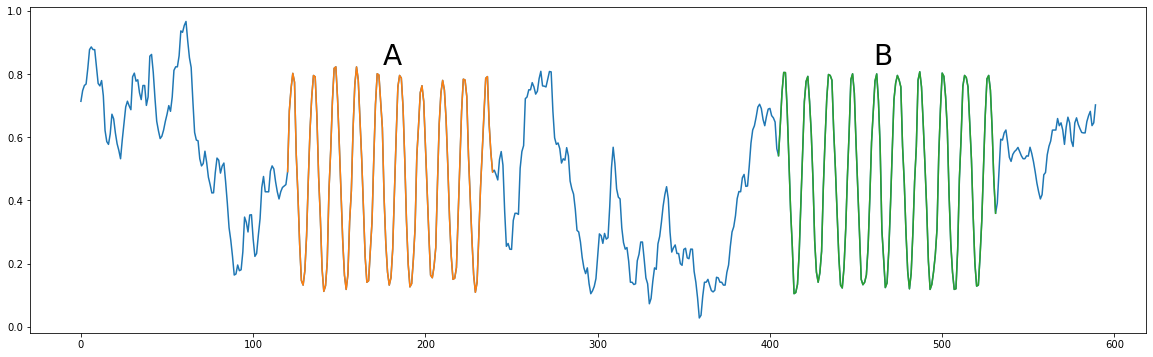

In [94]:
T = pd.read_pickle("31_1_yankov1.csv")
x = np.array(range(len(T)))

m_a, m_b = 120, 127
idx_a, idx_b = 120, 405
T_A, T_B = T[idx_a:idx_a+m_a], T[idx_b:idx_b+m_b]

plt.plot(T)
plt.plot(x[idx_a:idx_a+m_a], T_A, color="C1")
plt.plot(x[idx_b:idx_b+m_b], T_B, color="C2")
plt.text(175, 0.83, "A", fontsize=28)
plt.text(460, 0.83, "B", fontsize=28)
plt.show()

It looks A and B are identical.  
Let's plot them at same figure to make sure if A and B is truly identical and caluculate cummulative euclidean distance also.

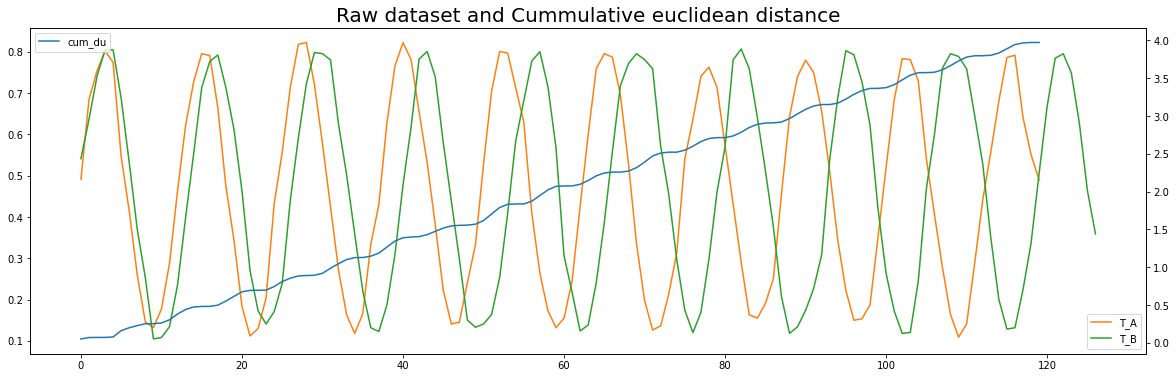

In [95]:
# cummulative euclidean distance
cum_du_raw = []
for i in range(1, m_a+1):
    cum_du_raw.append(np.linalg.norm(T_A[:i]-T_B[:i]))

ax1 = plt.axes()
ax1.plot(T_A, color="C1", label="T_A")
ax1.plot(T_B, color="C2", label="T_B")
plt.legend(loc=4)

ax2 = ax1.twinx()
ax2.plot(cum_du_raw, label="cum_du")
plt.title("Raw dataset and Cummulative euclidean distance", fontsize=20)
plt.legend(loc=2)
plt.show()

A and B are almost "same shape" signal but they are `out-of-phase`. So cummulative distance continues to be increased.  
By the increased distance,  A and B appear to be a completely different signals from the perspective of **euclidean distance**.

1. How does `uniform scaling` solve this problem?  
It adjusts phase shift to match phase by scaling a signal of them.

2. How about `uniform scaling` calculation?   
Insted of directrly computing time series A: $T_A$ and B: $T_B$,  
Here we have, scaling can be computed by `scipy.interpolate`.  
Its function creates model to interpolate signals, the model make **streching and shrinking signal** possible.  
If we can prepare scaled $T_A$ ( $T_A^{s}$ ), euclidean distance calculation itself is completly same with $T_A^{s}$ and $T_B$.  
All that's left is to define search range for scaling factor.

Let's find best scale factor to minimize cummulative distance. As search range is `100% ~ 150%`.

In [96]:
range_scaling = np.arange(1.0, 1.5, 0.01)
x_Ta = np.arange(m_a)
fitted_curve = interpolate.PchipInterpolator(x_Ta, T_A)

du = []  # euclidean distance
for i_scale in range_scaling:
    x_dummy = np.arange(0, m_a, 1/i_scale)
    T_As = fitted_curve(x_dummy)
    if len(T_As) >= len(T_B):
        du.append(np.linalg.norm(T_As[:len(T_B)]-T_B))
    else:
        du.append(np.linalg.norm(T_As-T_B[:len(T_As)]))

# scaled series re-calculation
scale_factor = range_scaling[np.argmin(du)]
x_dummy = np.arange(0, m_a, 1/scale_factor)
T_As = fitted_curve(x_dummy)

# cummulative euclidean distance 
cum_du_scaling = []
for i in range(1, m_b+1):
    cum_du_scaling.append(np.linalg.norm(T_As[:i]-T_B[:i]))

du_raw = cum_du_raw[-1]  # euclidian distance raw
du_scaling = cum_du_scaling[len(cum_du_raw)]  # euclidian distance scaling

print(f"scaling factor for minimum Euclidean distance is {scale_factor:.2f}")
print(f"Euclidean distance is improved to {du_scaling:.3f} from {du_raw:.3f} ({((du_raw-du_scaling)/du_raw)*100:.2f}% improved)")

scaling factor for minimum Euclidean distance is 1.06
Euclidean distance is improved to 0.651 from 3.972 (83.62% improved)


By scaling by `1.06%`, cummulative distance is improved `83.62%`.  
The distance is improved dramatically, it seems A should be phase with B now.  

Let's plot scaled dataset and compare how the distance is changed.

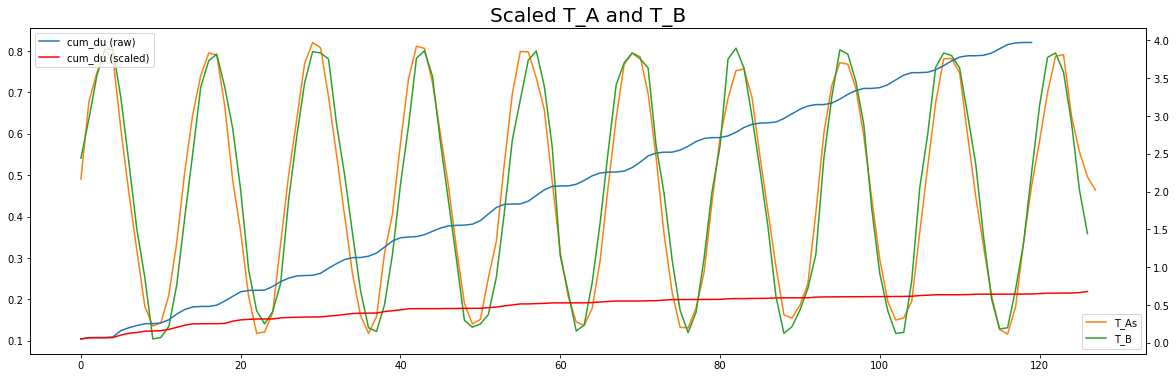

In [97]:
ax1 = plt.axes()
ax1.plot(T_As, color="C1", label="T_As")
ax1.plot(T_B, color="C2", label="T_B")
plt.legend(loc=4)

ax2 = ax1.twinx()
ax2.plot(cum_du_raw, label="cum_du (raw)")
ax2.plot(cum_du_scaling, label="cum_du (scaled)", color="r")
plt.title("Scaled T_A and T_B", fontsize=20)
plt.legend(loc=2)
plt.show()

As you can see above, streached $T_A$( $T_A^{s}$ ) is phase with $T_B$ well. Therefore cummulative distance doesn't increase along the time axis.  
Now you can find $T_A$ and $T_B$ as top-motif by **uniform scaling with euclidean distance**.

## Uniform scaling with Matrix Profile

Scaling logic above can be appiled to Matrix Profile simply.  
Here is a random walk time series for demostration from the MALLAT dataset and Matrix profile caluculation by `stumpy.stump`.  
After checking Matrix profile with raw dataset out, Let's demonstrate.

In [98]:
T = pd.read_pickle("31_1_MALLAT.csv") 
m = 1024  # window size

l = len(T)
x = np.arange(l)
mp = stumpy.stump(T, m)
idx_a = np.argmin(mp[:, 0])
idx_b = mp[:, 1][idx_a]

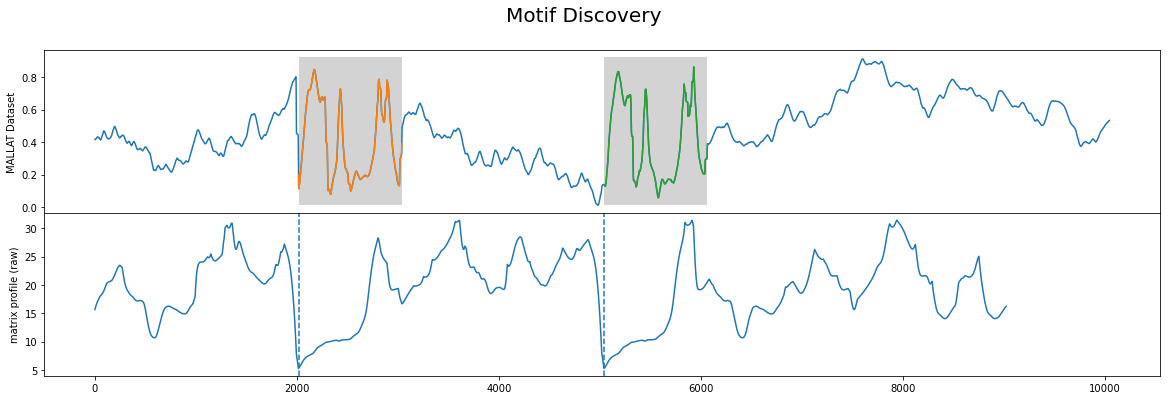

In [99]:
fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Motif Discovery', fontsize='20')
axs[0].plot(T)
axs[0].plot(x[idx_a:idx_a+m], T[idx_a:idx_a+m])
axs[0].plot(x[idx_b:idx_b+m], T[idx_b:idx_b+m])
axs[0].set_ylabel("MALLAT Dataset")
rect = Rectangle((idx_a, np.min(T)), m, np.max(T), facecolor='lightgrey')
axs[0].add_patch(rect)
rect = Rectangle((idx_b, np.min(T)), m, np.max(T), facecolor='lightgrey')
axs[0].add_patch(rect)

axs[1].plot(mp[:, 0])
axs[1].axvline(idx_a, linestyle="dashed")
axs[1].axvline(idx_b, linestyle="dashed")
axs[1].set_ylabel("matrix profile (raw)")
plt.show()

The color highlighting indicates top-1 motif, which unsurprisingly are exactly the imbedded patterns.  
The matrix profile corresponding to the random walk time series. The minimum values correspond to the top-1 motif in the time series.

Let's demonstrate how unifrom scaling can affect motif discovery in **streching case(1)** and **shrking case(2)**.



### 1. Streching
The searched scaling range is `150% ~ 180%` as an illustrative example.

In [105]:
range_scaling = np.arange(1.5, 1.8, 0.01)
l_ = len(T) - m + 1

P_updated = np.full(l_, np.inf, dtype=np.float64)
I_updated = np.zeros(l_, dtype=np.float64)
minScale = np.full(l_, np.nan, dtype=np.float64)

x_T = np.arange(len(T))
fitted_curve = interpolate.PchipInterpolator(x_T, T)

# Search scaling factor
for scale_factor in range_scaling:
    scale_factor_ = 1 / scale_factor
    x_dummy = np.arange(0, len(x_T), scale_factor_)
    Ts = fitted_curve(x_dummy)

    mp = stumpy.stump(T, m, Ts, ignore_trivial=False)
    mask = mp[:, 0] < P_updated
    P_updated[mask] = mp[mask, 0]
    I_updated[mask] = mp[mask, 1]
    minScale[mask] = scale_factor

idx_min = np.argmin(P_updated)

# stretched series re-calculation
scale_factor = minScale[idx_min]
scale_factor_ = 1 / scale_factor
x_dummy = np.arange(0, len(x_T), scale_factor_)
Ts = fitted_curve(x_dummy)
x_Ts = np.arange(len(Ts))

idx_min_s = int(I_updated[idx_min])

print(f"Best motif is found by scaling factor {scale_factor:.2f}")

Best motif is found by scaling factor 1.730


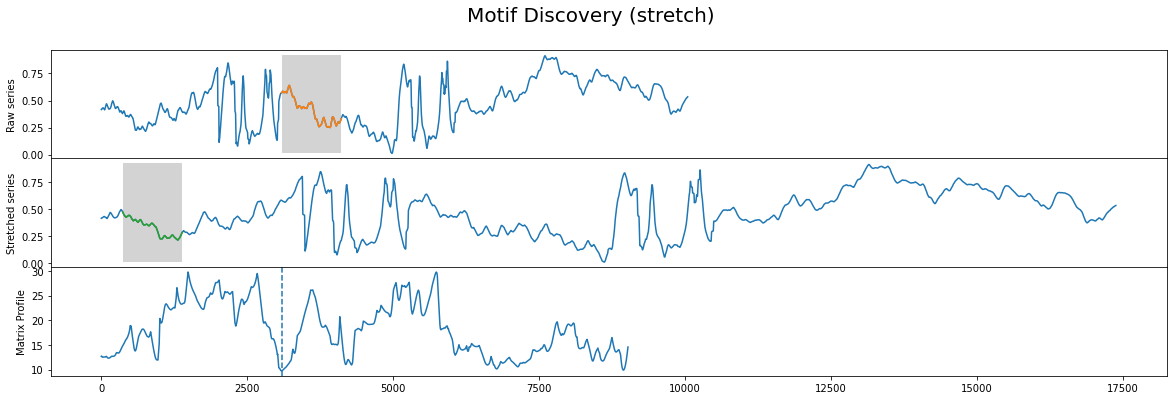

In [101]:
fig, axs = plt.subplots(3, 1, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Motif Discovery (stretch)', fontsize='20')
axs[0].plot(T)
axs[0].plot(x_T[idx_min:idx_min+m], T[idx_min:idx_min+m])
rect = Rectangle((idx_min, np.min(T)), m, np.max(T), facecolor='lightgrey')
axs[0].add_patch(rect)
axs[0].set_ylabel("Raw series")

axs[1].plot(Ts)
axs[1].plot(x_Ts[idx_min_s:idx_min_s+m], Ts[idx_min_s:idx_min_s+m], color="C2")
rect = Rectangle((idx_min_s, np.min(Ts)), m, np.max(Ts), facecolor='lightgrey')
axs[1].add_patch(rect)
axs[1].set_ylabel("Stretched series")

axs[2].plot(P_updated)
axs[2].axvline(idx_min, color="C0", linestyle="--")
axs[2].set_ylabel("Matrix Profile")

plt.show()

The best-motif is highlighted orange subsequence from raw dataset(1th panel), and green subsequence from streched sequence by 173% of raw dataset(2th pannel).  
Those are completly different motif from "normal motif discovery".

### 2. Shrinking
The searched scaling range is `30% ~ 70%` as an illustrative example.

In [106]:
range_scaling = np.arange(0.3, 0.7, 0.01)
l_ = len(T) - m + 1

P_updated = np.full(l_, np.inf, dtype=np.float64)
I_updated = np.zeros(l_, dtype=np.float64)
minScale = np.full(l_, np.nan, dtype=np.float64)

x_T = np.arange(len(T))
fitted_curve = interpolate.PchipInterpolator(x_T, T)

# Search scaling factor
for scale_factor in range_scaling:
    scale_factor_ = 1 / scale_factor
    x_dummy = np.arange(0, len(x_T), scale_factor_)
    Ts = fitted_curve(x_dummy)

    mp = stumpy.stump(T, m, Ts, ignore_trivial=False)
    mask = mp[:, 0] < P_updated
    P_updated[mask] = mp[mask, 0]
    I_updated[mask] = mp[mask, 1]
    minScale[mask] = scale_factor

idx_min = np.argmin(P_updated)

# shrunk series re-calculation
scale_factor = minScale[idx_min]
scale_factor_ = 1 / scale_factor
x_dummy = np.arange(0, len(x_T), scale_factor_)
Ts = fitted_curve(x_dummy)
x_Ts = np.arange(len(Ts))

idx_min_s = int(I_updated[idx_min])

print(f"Best motif is found by scaling factor {scale_factor:.2f}")

Best motif is found by scaling factor 0.44


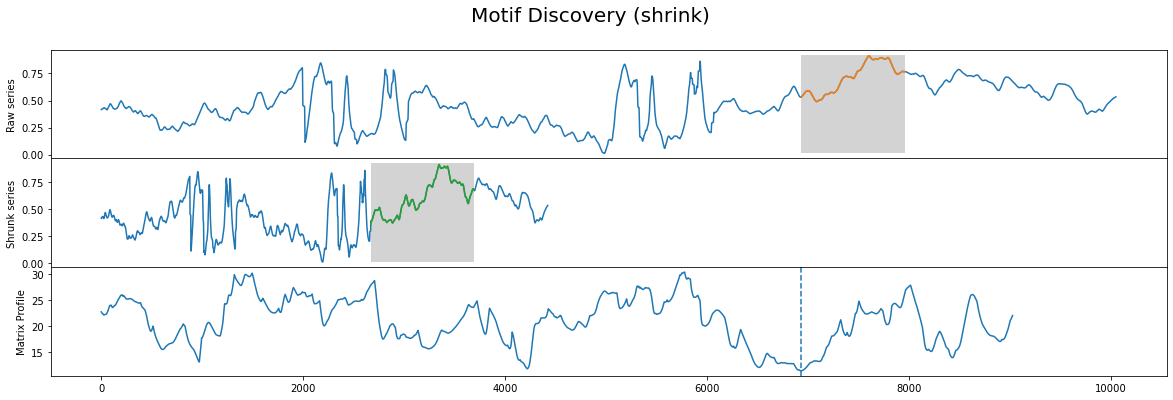

In [103]:


fig, axs = plt.subplots(3, 1, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Motif Discovery (shrink)', fontsize='20')
axs[0].plot(T)
axs[0].plot(x_T[idx_min:idx_min+m], T[idx_min:idx_min+m])
rect = Rectangle((idx_min, np.min(T)), m, np.max(T), facecolor='lightgrey')
axs[0].add_patch(rect)
axs[0].set_ylabel("Raw series")

axs[1].plot(Ts)
axs[1].plot(x_Ts[idx_min_s:idx_min_s+m], Ts[idx_min_s:idx_min_s+m], color="C2")
rect = Rectangle((idx_min_s, np.min(Ts)), m, np.max(Ts), facecolor='lightgrey')
axs[1].add_patch(rect)
axs[1].set_ylabel("Shrunk series")

axs[2].plot(P_updated)
axs[2].axvline(idx_min, color="C0", linestyle="--")
axs[2].set_ylabel("Matrix Profile")

plt.show()

The best-motif is highlighted orange subsequence from raw dataset(1th panel), and green subsequence from streched sequence by 44% of raw dataset(2th pannel).  
Those are alse completly different motif from "normal motif discovery".

Now, the resulting Matrix Profile will discover the motifs with the appropriate uniform scaling invariance.  
To the best of our knowledge, there is only one research effort that has addressed this (Yankov 2007)[2]. However, this method is approximate, requires many parameters to be set,  
and is only able to support a limited range of scaling.  In contrast, we can easily and exactly solve this problem under our simple assumptions.

This example perfectly elucidates the philosophy driving this paper.  
For many time series data mining tasks, we may not need to spend significant human time
designing, implementing and tuning new algorithms.  
The Matrix Profile and ten lines of code may be sufficient.

## References
[1]: [The Swiss Army Knife of Time Series Data Mining: Ten Useful Things You Can Do With The Matrix Profile And Ten Lines Of Code](https://www.cs.ucr.edu/~eamonn/Top_Ten_Things_Matrix_Profile.pdf) (see Section 3.1)

[2]: Yankov 2007: [Detecting time series motifs under uniform scaling. In: Proceedings of the 2007 ACM SIGKDD](https://dl.acm.org/doi/10.1145/1281192.1281282)  